In [129]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")
_set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "patient-ai-chat"

In [130]:
class Tools:
    def request_medication_change(previous_medication: str) -> str:
        """Puts a request to the doctor for medication change.

        Returns a string with the name of current medication and Change request submitted.

        Args:
            previous_medication: first str
        """
        return "Change request submitted for " + previous_medication


    def make_appointment(date: str, reason: str) -> str:
        """Puts an appointment request on the specified date and reason.

        Returns a string with the reason for the requested appointment and date for the appointment

        Args:
            date: first str
            reason: second str
        """
        return "Appointment requested on " + date + " for " + reason


    def request_appointment_change(past_date: str, requested_date: str) -> str:
        """Puts an appointment change request for a given date and requested.

        Returns a string with the changed and previous date for appointment.

        Args:
            past_date: first str
            requested_date: second str
        """
        return past_date + " " + requested_date


In [131]:
prompt_text = '''You are a helpful AI medical assistant namely Patient Chat and are developed by a software 
    engineer named Sajed. 
    You should only respond to health-related topics such as: 
    - General human health and lifestyle inquiries.
    - Questions about men, women and children health
    - Questions about the patient's medical condition, medication regimen, diet, etc. 
    - Various requests from the patient to their doctor such as make appointments, modify appointments and medication changes. 
    You should filter out and ignore any unrelated, overly sensitive, or controversial topics.'''

In [132]:
from langchain_anthropic import ChatAnthropic
from langgraph.graph import START, StateGraph, MessagesState, END
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver

In [133]:
def bind_tools():
    tool_list = [Tools.request_medication_change, Tools.make_appointment, Tools.request_appointment_change]
    return model.bind_tools(tool_list)

In [134]:
class State(MessagesState):
    summary: str

def assistant(state: State):
    # Prompt message
    sys_msg = SystemMessage(content=prompt_text)
    model_with_tools = model.bind_tools(tool_list)
    return {"messages": [model_with_tools.invoke([sys_msg] + state["messages"])]}


In [135]:
from typing import Literal


def summarize_conversation(state: State):
    
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", "__end__"]:
    messages = state["messages"]
    
    # If there are more than four messages, then we summarize the conversation
    if len(messages) >= 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return "__end__"

In [145]:
def build_graph() -> CompiledStateGraph:
    builder = StateGraph(State)
    builder.add_node("assistant", assistant)
    builder.add_node("tools", ToolNode(tool_list))
    builder.add_node(summarize_conversation)

    builder.add_edge(START, "assistant")
    builder.add_conditional_edges("assistant", tools_condition)
    builder.add_conditional_edges("assistant", should_continue)
    builder.add_edge("tools", "assistant")
    builder.add_edge("summarize_conversation", END)
    
    memory = MemorySaver()
    return builder.compile(checkpointer=memory)
    

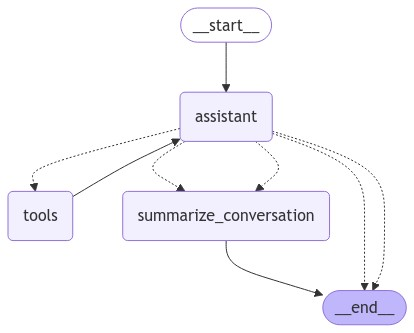

In [146]:
from IPython.display import Image, display

model = ChatAnthropic(model="claude-3-haiku-20240307")
tool_list = [Tools.request_medication_change, Tools.make_appointment, Tools.request_appointment_change]
graph = build_graph()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [147]:
messages = [HumanMessage(content="My name is Sajed")]
config = {"configurable": {"thread_id": "3"}}
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

My name is Sajed
================================== Ai Message ==================================

It's nice to meet you Sajed. As your AI medical assistant, I'm here to help you with any health-related questions or requests. Please feel free to let me know how I can assist you. I'll do my best to provide helpful information or take the necessary actions on your behalf. What would you like help with today?


In [148]:
messages = [HumanMessage(content="What is my name?")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Sajed, as you mentioned earlier.


In [149]:
graph.get_state(config).values.get("summary","")

"Here's a summary of our conversation so far:\n\nYou introduced yourself and told me your name is Sajed. As an AI medical assistant, I greeted you and said I'm here to help with any health-related questions or requests you may have. I asked what I could assist you with today. You then asked what your name is, and I reminded you that you had stated your name is Sajed earlier in our conversation."

In [140]:
messages = [HumanMessage(content="What is my name?")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

My name is Sajed
================================== Ai Message ==================================

It's nice to meet you Sajed! As an AI medical assistant, I'm here to assist you with health-related topics. Please let me know if you have any questions about your medical condition, medication, diet, or if you need help making or changing any appointments with your doctor. I'm happy to help in any way I can within the scope of my capabilities as a healthcare-focused AI.
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I'm sorry, but I don't actually know your name. In our previous exchange, you introduced yourself as Sajed, but I don't have any other personal information about you stored. As an AI assistant, I don't have the ability to remember or track individual users' identi

In [141]:
graph.get_state(config).values.get("summary","")

''

In [126]:
messages = [HumanMessage(content="I have an appointmnet on October 9. I want to reschedule it to November 5th.")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

My name is Sajed
================================== Ai Message ==================================

It's nice to meet you Sajed. As an AI medical assistant, I'm happy to help you with any health-related inquiries you may have. Please feel free to ask me questions about your health, medications, diet, or anything else related to your wellbeing. I'll do my best to provide helpful information or direct you to the appropriate resources. What would you like assistance with today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

You said your name is Sajed.
================================ Human Message =================================

I have an appointmnet on October 9. I want to reschedule it to November 5th.
================================== Ai Message ========================

In [128]:
graph.get_state(thread).values.get("summary","")

''